# This notebook is...
a copy of [Your first NLP competition submission](https://www.kaggle.com/code/naim99/your-first-nlp-competition-submission/notebook) by Mhedhbi, with some comments and varation by myself.... but in korean.

# 텍스트 분류 단계별로 해보자

자연어 처리(Natural Language Processing, NLP)는 많은 자연어 데이터를 분석, 처리해야 한다. 언어를 읽고 이해한다는 것이 생각보다 어렵다. 

## 목표
- 기본적인 탐험적 데이터 분석 (EDA)
- 데이터셋 clean
- Feature 분석, 추출
- 모델, 평가 메트릭 세우기
- 결과 제출하기

# 1. 개요: 데이터에 대해
- 세 개의 파일
- 트윗의 텍스트, 키워드(없는 경우 있음), 트윗을 보낸 장소(없는 경우 있음)
- 예측 해야 하는 것은 트윗이 재난상황에 대한 것인지 아닌지에 대한 label.
- 데이터셋의 칼럼: id(트윗별 고유 식별자. Q)사람 아닌가?), text, location, keyword, target

# 2. 데이터 불러오고 확인해보기
## import library

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


__os.walk의 활용__  
데이터 파일 이름을 입력하는 것이 아니라 특정 디렉토리의 파일 경로+이름을 읽어오는 os.walk() 를 활용하고 있습니다.

In [2]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import BlanklineTokenizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

#looks like it was originally separated parts... as top and bottom side of this line

import scikitplot as skplt
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

#It looks like another part.
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 패키지/라이브러리 불러오는 도중의 문제:
keras.optimizers.Adam 이 없다고 하여 tensorflow.keras.optimizers.Adam 을 대신 불러왔다.  
중복이 많은데 그건 무시하도록 하자. 약 세 파트를 이어붙인 것 같다.  

## Import Dataset

In [3]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('{} rows, {} columns in train.csv'.format(train_data.shape[0], train_data.shape[1]))
print('{} rows, {} columns in test.csv'.format(test_data.shape[0], test_data.shape[1]))

7613 rows, 5 columns in train.csv
3263 rows, 4 columns in test.csv


In [5]:
train_data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [6]:
train_data.sample(1)['text']

1942    Rite now man a tlk widout nuh curfew long side...
Name: text, dtype: object

In [7]:
# 3. 탐험적 데이터 분석 (EDA)
## 타겟 변수의 분포

In [8]:
x=train_data.target.value_counts()
print(x)

0    4342
1    3271
Name: target, dtype: int64


0 (재난 트윗 아님)이 더 많긴 한데 비슷하다.

## 트윗 탐험적 분석  
먼저 기본적인 분석으로 문자, 단어, 문장 수준으로 나눠서 보자.  
트윗들의 문자수는

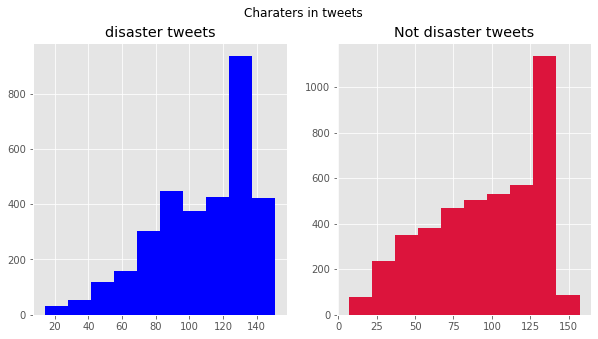

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
tweet_len = train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='CRIMSON')
ax2.set_title('Not disaster tweets')
fig.suptitle('Charaters in tweets')
plt.show()

양쪽 분포 거의 같다. 120~140이 제일 많음

### 트윗당 단어 수

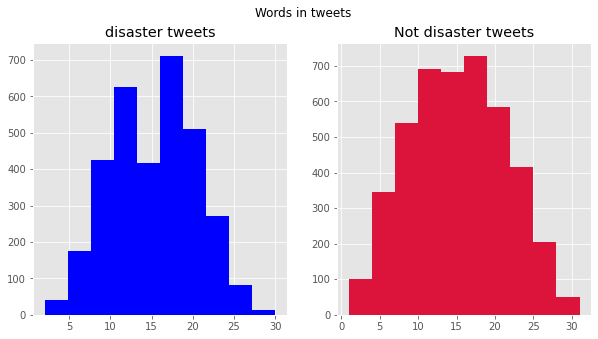

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
tweet_len = train_data[train_data['target']==1]['text'].str.split().map(len)
#map apply function to each elements. so lambda function is not required
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.split().map(len)
ax2.hist(tweet_len, color='CRIMSON')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in tweets')
plt.show()

### 트윗당 평균 단어 수

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


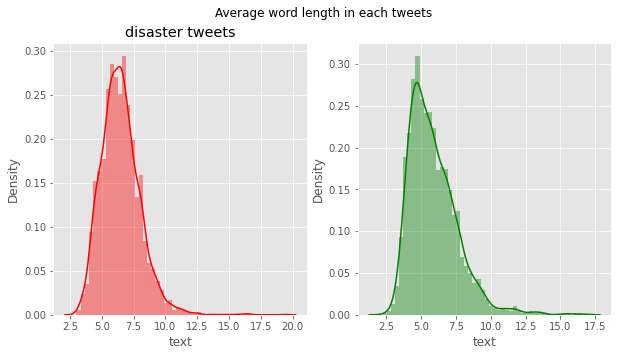

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
word=train_data[train_data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(np.mean), ax=ax1, color='red') #also no lambda funcion required
ax1.set_title('disaster tweets')
word=train_data[train_data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(np.mean), ax=ax2, color='green') #also no lambda funcion requiredax2.set_title('Not disaster tweets')
fig.suptitle('Average word length in each tweets')
plt.show()

### 트윗당 평균 단어수 : seaborn의 권장 포맷
distplot()이 future warning을 띄우길래 한번 해봤습니다. 대신 displot()을 써야 합니다.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


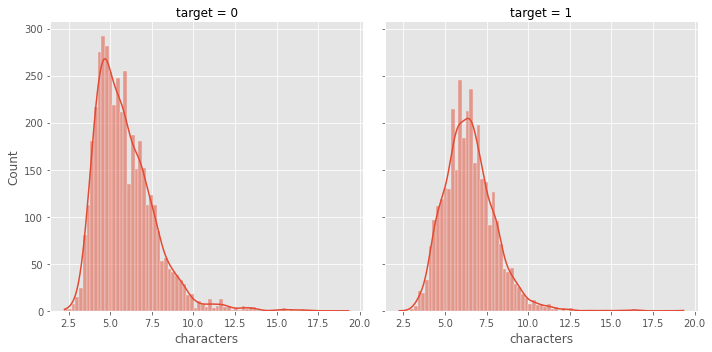

In [12]:
#to avoid 'futurewarning' by seaborn, use FecetGrid() and displot() 
words_len=train_data[['text','target']] #why [[]]???
words_len['characters']=train_data['text'].str.split().apply(lambda x: np.mean([len(i) for i in x]))

g=sns.displot(data=words_len, x='characters', col='target', kde=True, height=5, aspect=1.0)
#it returns FacetGrid object

del words_len

__Frequencies__ 전체 말뭉치(Corpus)에서의 빈도

In [13]:
corpus=[]
for x in train_data['text'].str.split():
    for i in x:
        corpus.append(i)

In [14]:
dic = defaultdict(int)
dic=defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word]+=1

<BarContainer object of 30 artists>

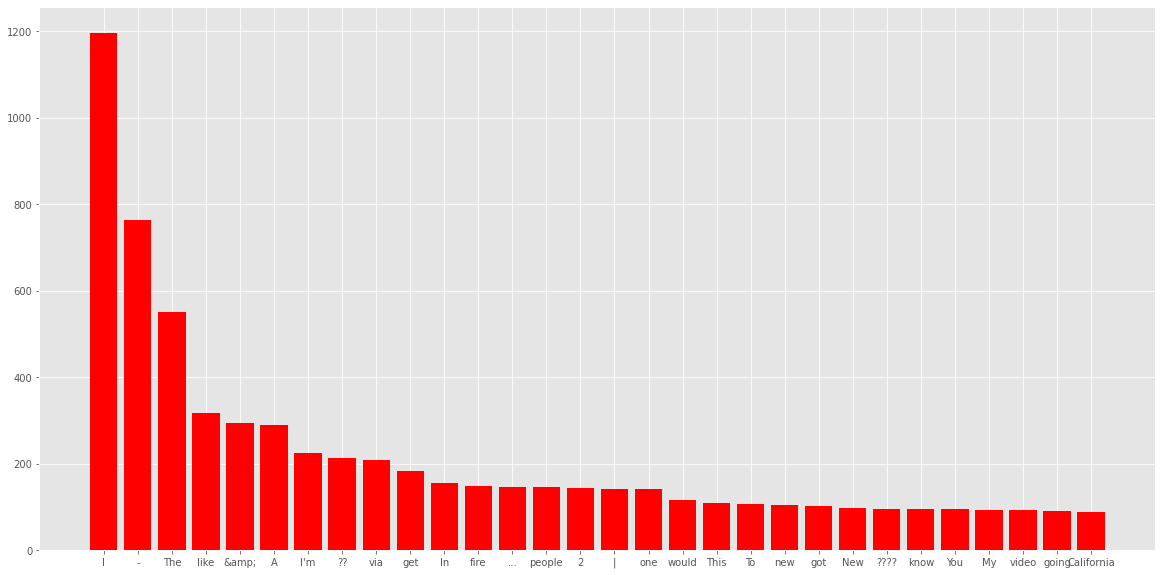

In [15]:
top=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:30]
#items return tuples of which second element is value.
#So top returns list of (key, value) of descending value[:30]

x, y=zip(*top)
plt.rcParams['figure.figsize'] = (20, 10)
plt.bar(x,y,color='red')

<BarContainer object of 30 artists>

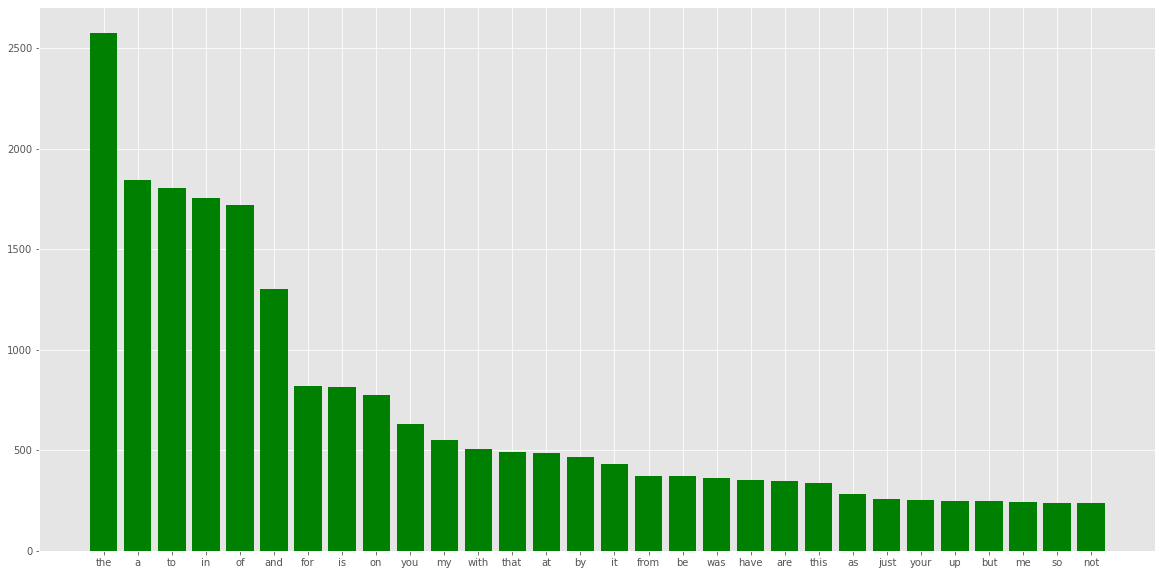

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

        top=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:30]
        
x, y = zip(*top)
plt.rcParams['figure.figsize'] = (20, 10)
plt.bar(x,y,color='green')

Q) defaultdict(int) 이것은 뭐 하는 건가?

어떤 구두점이 있나 한 번 보자고 하네요.

<BarContainer object of 23 artists>

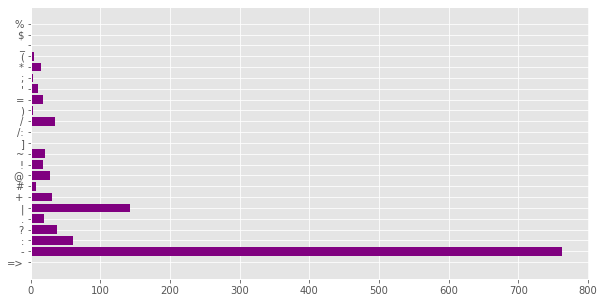

In [17]:
plt.figure(figsize = (10,5))
import string
dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x, y, = zip(*dic.items())
plt.barh(x, y, color = 'purple')

각 단어를 들여다봅시다??

In [18]:
from collections import Counter
words = train_data[train_data.target==0].text.apply(lambda x: [word.lower() for word in x.split()])
h_words = Counter()

for text_ in words:
    h_words.update(text_)

print(h_words.most_common(50))

[('the', 1877), ('a', 1238), ('to', 1181), ('i', 1052), ('and', 911), ('of', 895), ('in', 805), ('you', 625), ('is', 586), ('my', 541), ('for', 486), ('on', 424), ('with', 374), ('-', 374), ('that', 357), ('it', 341), ('this', 286), ('be', 284), ('like', 250), ('have', 240), ('by', 240), ('so', 235), ('are', 231), ('at', 229), ('just', 229), ('your', 225), ('me', 221), ('was', 216), ('but', 216), ('not', 198), ("i'm", 195), ('&amp;', 190), ('??', 183), ('out', 179), ('up', 178), ('will', 177), ('if', 177), ('from', 177), ('all', 173), ('new', 163), ('get', 161), ('as', 160), ('or', 155), ('we', 148), ('when', 144), ('has', 143), ('he', 143), ('no', 140), ('about', 139), ('they', 133)]


In [19]:
from collections import Counter
words = train_data[train_data.target==1].text.apply(lambda x: [word.lower() for word in x.split()])
h_words = Counter()

for text_ in words:
    h_words.update(text_)

print(h_words.most_common(50))

[('the', 1330), ('in', 1144), ('of', 919), ('a', 897), ('to', 753), ('and', 494), ('on', 410), ('for', 394), ('-', 389), ('is', 344), ('at', 303), ('i', 284), ('by', 274), ('from', 243), ('with', 188), ('that', 181), ('after', 181), ('this', 177), ('as', 167), ('are', 166), ('was', 165), ('it', 163), ('fire', 151), ('have', 140), ('my', 130), ('over', 123), ('you', 121), ('more', 121), ('via', 117), ('up', 114), ('an', 113), ('be', 112), ('...', 106), ('&amp;', 105), ('has', 104), ('suicide', 103), ('who', 100), ('no', 99), ('disaster', 97), ('but', 95), ('police', 94), ('people', 93), ('been', 93), ('when', 93), ('killed', 92), ('like', 91), ('not', 90), ('california', 88), ('than', 85), ('just', 84)]


Q) counter는 어디 있던 거지?

## 탐험적 분석 - 다른 변수들

### Keyword, location

__빈 값들__

빈 값의 비율은 train, test 양쪽에서 비슷했고, 0.8%에서 키워드가, 33%에서 location이 없었다. 빈 데이터를 no_keyword, no_location으로 채우자.

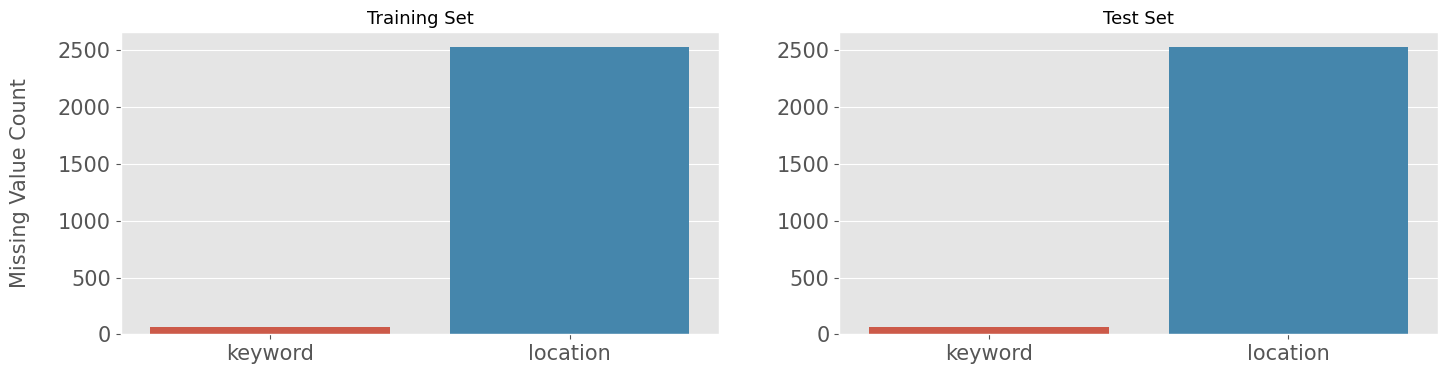

In [22]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17,4), dpi=100)

sns.barplot(x=train_data[missing_cols].isnull().sum().index,
           y=train_data[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=train_data[missing_cols].isnull().sum().index,
           y=train_data[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train_data, test_data]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

인상적인 구문 : 
```python
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col'})
```
__cardinality와 (cardinal : 양을 표시하는 기수) 타겟__  
Location은 사용가자 입력해야 된다고 합니다. 그래서 feature로 쓰기 더럽다고 하네요.  

다행히 keyword는 쓸만한데 타겟으로 쓸 수 있을 정도라고 하고, train에 나온 키워드는 test에 다 나온다고 합니다.

In [24]:
print(f'Number of unique values in keyword = {train_data["keyword"].nunique()} (Training) - {test_data["keyword"].nunique()} (Test)')
print(f'Number of unique values in keyword = {train_data["keyword"].nunique()} (Training) - {test_data["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in keyword = 222 (Training) - 1603 (Test)


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


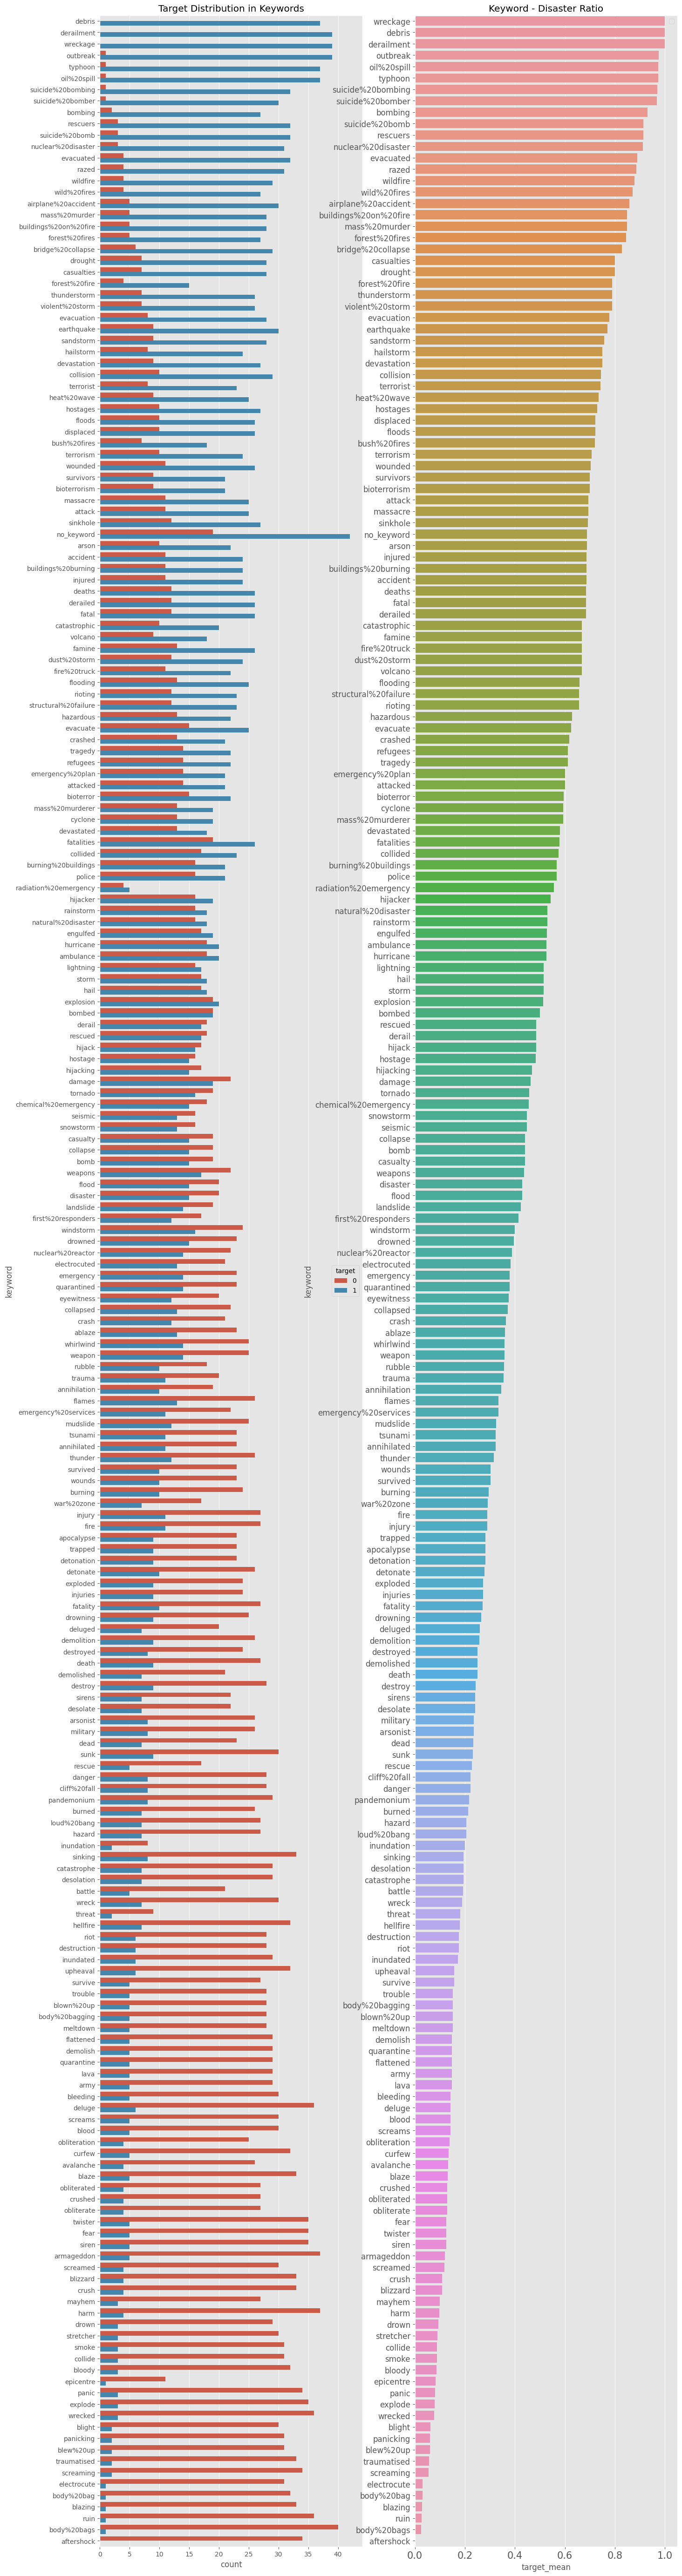

In [97]:
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 72), dpi=100)

sns.countplot(y=train_data.sort_values(by='target_mean', ascending=False)['keyword'],
             hue=train_data.sort_values(by='target_mean', ascending=False)['target'], ax=ax1)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
ax1.title.set_text('Target Distribution in Keywords')

#calculate disaster ratio of each keyword

c=train_data[['keyword', 'target_mean']]
c.drop_duplicates(inplace=True) #it works without this line. but seems it is slower....
c.sort_values(by='target_mean', ascending=False, inplace=True)
sns.barplot(x=c.target_mean, y=c.keyword, ax=ax2)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
ax2.title.set_text('Keyword - Disaster Ratio')
plt.show()

train_data.drop(columns=['target_mean'], inplace=True)


## 해쉬태그 분석
이게 뭔소린지 모르겠다.
| Small analysis done on the hashtags, to check it's possible discriminator #capability for this task.

__정규 표현식__
suffices for our case - 이것도 뭔소린지 모르겠다. r'^(\d{4})' 은 4자리 숫자가 아닌 것을 뜻한다.

In [27]:
def clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    
    #remove numbers
    df[new_text_field_name]=df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    #remove url
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"https?://\S+|www\.\S+","",elem))
    #remove HTML tags
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"<.*?>", "", elem))
    #remove emojis
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"["
                                                                                u"\U0001F600-\U0001F64F"#emots
                                                                                u"\U0001F300-\U0001F5FF"#symbols &pictographs
                                                                                u"\U0001F680-\U0001F6FF" #transport&map symbol
                                                                                u"\U0001F1E0-\U0001F1FF" #flgas(ios)
                                                                                u"\U00002702-\U000027B0"
                                                                                u"\U000024C2-\U0001F251"
                                                                                "]+", "", elem))
    return df
data_clean = clean_text(train_data, 'text', 'text_clean')
data_clean_test=clean_text(test_data, 'text', 'text_clean')
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


__Q) clean_text 마지막에 뭐 한 것인가?__
일단 u는 유니코드, 